In [1]:
import numpy as np
import pandas as pd
from itertools import cycle

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb

In [4]:
import warnings
import multiprocessing

In [5]:
df_sales = pd.read_csv('sales.csv.gz')
df_items = pd.read_csv('item.csv.gz')
holidays = pd.read_csv('holidays.csv.gz')

In [6]:
display(df_sales.shape)
display(df_items.shape)

(2751672, 4)

(3481, 4)

In [7]:
df_items.head()

,item_nbr,family,class,perishable
0,270522,AUTOMOTIVE,6806,0
1,1085148,AUTOMOTIVE,6806,0
2,1085150,AUTOMOTIVE,6806,0
3,1118683,AUTOMOTIVE,6806,0
4,1147731,AUTOMOTIVE,6806,0


In [8]:
df_sales.head()

,date,item_nbr,onpromotion,unit_sales
0,2014-04-01,103520,0,8
1,2014-04-01,103665,0,9
2,2014-04-01,105575,0,28
3,2014-04-01,105577,0,5
4,2014-04-01,105693,0,2


In [9]:
holidays.head()

,date,holiday_flag,workday,weekend,work_on_weekend
0,2014-04-01,0,1,0,0
1,2014-04-02,0,1,0,0
2,2014-04-03,0,1,0,0
3,2014-04-04,0,1,0,0
4,2014-04-05,0,0,1,0


In [10]:
holidays.date = pd.to_datetime(holidays.date)

In [11]:
df = pd.merge(df_sales, df_items, on='item_nbr', how='left')

In [12]:
display( df.item_nbr.nunique() )
display( df.date.nunique() )

3481

1227

In [13]:
display( pd.to_datetime(df.date).min() )
display( pd.to_datetime(df.date).max() )

Timestamp('2014-04-01 00:00:00')

Timestamp('2017-08-15 00:00:00')

In [14]:
dates = pd.date_range(start='2014-04-01', end='2017-08-15', freq='1d')
dates.shape

(1233,)

In [15]:
df.head(3)

,date,item_nbr,onpromotion,unit_sales,family,class,perishable
0,2014-04-01,103520,0,8,GROCERY I,1028,0
1,2014-04-01,103665,0,9,BREAD/BAKERY,2712,1
2,2014-04-01,105575,0,28,GROCERY I,1045,0


In [16]:
df_piv = pd.pivot_table(df, 'unit_sales', 'date', 'family', sum)
df_piv.index = pd.to_datetime(df_piv.index)

In [17]:
df_piv_ds = pd.concat((df_piv.isnull().mean(), df_piv.mean(), df_piv.max(), df_piv.min(), df_piv.std(), df_piv.sum()), axis=1)
df_piv_ds.columns = ['nullrate', 'mean_sales', 'max_sales', 'min_sales', 'std_sales', 'sum_sales']
df_piv_ds

,nullrate,mean_sales,max_sales,min_sales,std_sales,sum_sales
family,,,,,,
AUTOMOTIVE,0.000000,18.834556,89.0,1.0,9.770675,23110.0
BEAUTY,0.744091,6.636943,74.0,1.0,9.016954,2084.0
BEVERAGES,0.000000,8168.773431,22970.0,2616.0,3389.371074,10023085.0
BOOKS,0.864711,3.180723,51.0,1.0,4.533096,528.0
BREAD/BAKERY,0.000000,1478.102689,3316.0,564.0,456.244760,1813632.0
CELEBRATION,0.221679,32.837696,919.0,3.0,43.698292,31360.0
CLEANING,0.000000,2585.463733,5836.0,1110.0,646.407667,3172364.0
DAIRY,0.000000,2556.638957,5247.0,1142.0,714.778126,3136996.0
DELI,0.000000,609.732681,1368.0,254.0,205.759367,748142.0


In [18]:
sales_date = pd.concat((df.groupby('family').date.min(), df.groupby('family').date.max()), axis=1)

In [19]:
sales_date.columns = ['t0', 't1']

In [20]:
df_piv_ds = pd.concat((df_piv_ds, sales_date), axis=1)

In [21]:
df_piv_ds.sort_values('sum_sales', ascending=False, inplace=True)

In [22]:
df_piv_ds.head(10)

,nullrate,mean_sales,max_sales,min_sales,std_sales,sum_sales,t0,t1
family,,,,,,,,
GROCERY I,0.000000,9992.079870,35555.0,4341.0,3274.928810,12260282.0,2014-04-01,2017-08-15
BEVERAGES,0.000000,8168.773431,22970.0,2616.0,3389.371074,10023085.0,2014-04-01,2017-08-15
PRODUCE,0.000815,8110.809951,17815.0,1.0,4970.405314,9943853.0,2014-04-01,2017-08-15
CLEANING,0.000000,2585.463733,5836.0,1110.0,646.407667,3172364.0,2014-04-01,2017-08-15
DAIRY,0.000000,2556.638957,5247.0,1142.0,714.778126,3136996.0,2014-04-01,2017-08-15
BREAD/BAKERY,0.000000,1478.102689,3316.0,564.0,456.244760,1813632.0,2014-04-01,2017-08-15
POULTRY,0.000000,1375.807661,2666.0,553.0,416.635354,1688116.0,2014-04-01,2017-08-15
MEATS,0.000000,973.429503,2094.0,375.0,312.556097,1194398.0,2014-04-01,2017-08-15
EGGS,0.000000,656.027710,1375.0,252.0,202.581720,804946.0,2014-04-01,2017-08-15


In [23]:
df_piv_ds.loc[df_piv_ds.t0 != '2014-04-01']

,nullrate,mean_sales,max_sales,min_sales,std_sales,sum_sales,t0,t1
family,,,,,,,,
HOME CARE,0.198859,625.384537,2214.0,199.0,254.585940,614753.0,2014-07-01,2017-08-15
HOME AND KITCHEN I,0.099430,111.771946,1929.0,14.0,106.039577,123508.0,2014-07-01,2017-08-15
HOME AND KITCHEN II,0.099430,89.250679,1568.0,6.0,86.836259,98622.0,2014-07-01,2017-08-15
PREPARED FOODS,0.824776,231.334884,528.0,18.0,144.519052,49737.0,2016-11-27,2017-08-15
PLAYERS AND ELECTRONICS,0.221679,43.445026,156.0,13.0,18.825967,41490.0,2014-07-01,2017-08-15
PET SUPPLIES,0.226569,34.284510,106.0,2.0,17.249998,32536.0,2014-07-01,2017-08-15
LADIESWEAR,0.221679,33.113089,100.0,3.0,16.731252,31623.0,2014-07-01,2017-08-15
CELEBRATION,0.221679,32.837696,919.0,3.0,43.698292,31360.0,2014-07-01,2017-08-15
SCHOOL AND OFFICE SUPPLIES,0.225754,30.394737,740.0,1.0,72.136980,28875.0,2014-07-01,2017-08-15


In [24]:
df_piv_ds.loc[df_piv_ds.t1 != '2017-08-15']

,nullrate,mean_sales,max_sales,min_sales,std_sales,sum_sales,t0,t1
family,,,,,,,,
HOME APPLIANCES,0.375713,2.793734,11.0,1.0,1.726915,2140.0,2014-04-01,2017-08-02
BOOKS,0.864711,3.180723,51.0,1.0,4.533096,528.0,2016-10-12,2017-07-15


In [113]:
family_imp = ( df_piv_ds.sum_sales.cumsum() / df_piv_ds.sum_sales.sum() ).to_frame()
family_imp.columns = ['ss_norm']
family_imp['diff'] = family_imp.ss_norm.diff()

In [118]:
family_imp.iloc[0:14]

,ss_norm,diff
family,,
GROCERY I,0.26,nan
BEVERAGES,0.46,0.21
PRODUCE,0.67,0.21
CLEANING,0.74,0.07
DAIRY,0.80,0.07
BREAD/BAKERY,0.84,0.04
POULTRY,0.87,0.04
MEATS,0.90,0.02
EGGS,0.92,0.02


In [130]:
imp_pfamilys = list(family_imp.iloc[0:14].index)

In [131]:
family_df = pd.pivot_table(df, 'unit_sales', 'date', 'family', sum)[imp_pfamilys].fillna(0).shift(1)

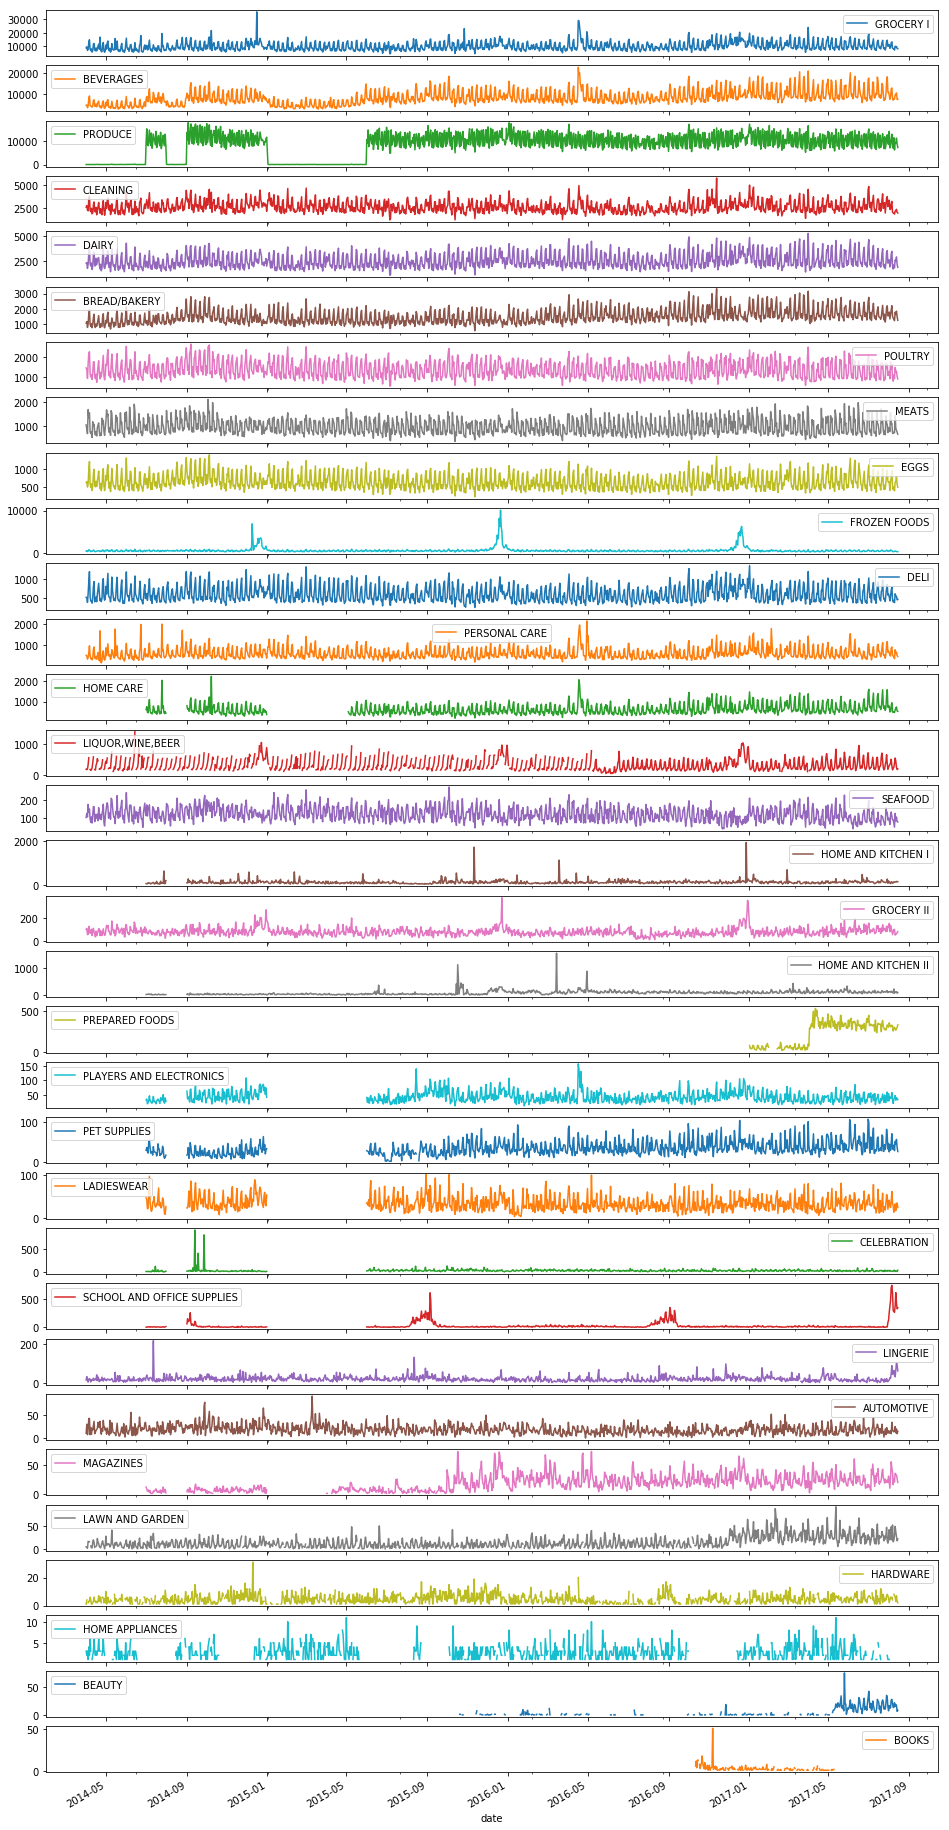

In [26]:
df_piv[df_piv_ds.index].plot(subplots=True, layout=(df_piv.columns.shape[0], 1), figsize=(16, 36));

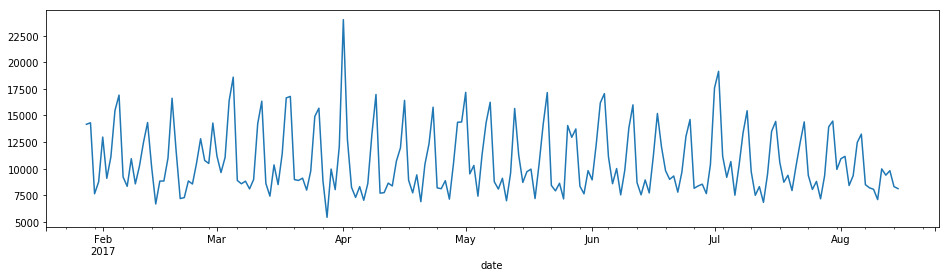

In [27]:
df_piv['GROCERY I'].tail(200).plot(figsize=(16, 4));

In [28]:
df.date = pd.to_datetime(df.date, infer_datetime_format=True)

In [29]:
sales_family = df.groupby(['family', 'date']).unit_sales.sum().reset_index()

In [30]:
sales_family['dow'] = sales_family.date.map(lambda x: x.dayofweek)
sales_family['month'] = sales_family.date.map(lambda x: x.month)

In [31]:
mean_dow = pd.pivot_table(sales_family, 'unit_sales', 'family', 'dow', np.mean)
mean_dow.columns = np.arange(1,8,1)
mean_month = pd.pivot_table(sales_family, 'unit_sales', 'family', 'month', np.mean)
means_family = sales_family.groupby('family').unit_sales.mean()
norm_mean_dow = mean_dow.apply(lambda x: x / means_family)
norm_mean_month = mean_month.apply(lambda x: x / means_family)

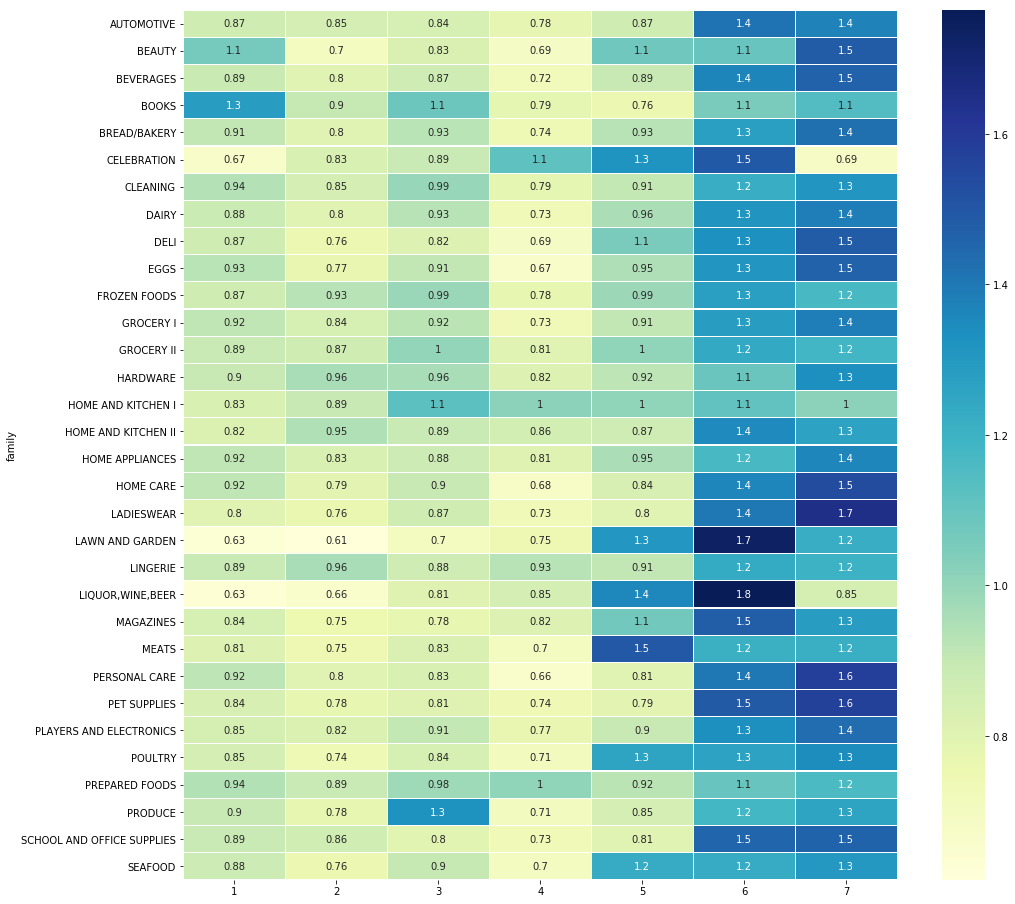

In [32]:
fig, ax = plt.subplots(figsize=(16,16)) 
ax = sns.heatmap(norm_mean_dow, annot=True, linewidths=.2, cmap="YlGnBu", ax=ax)

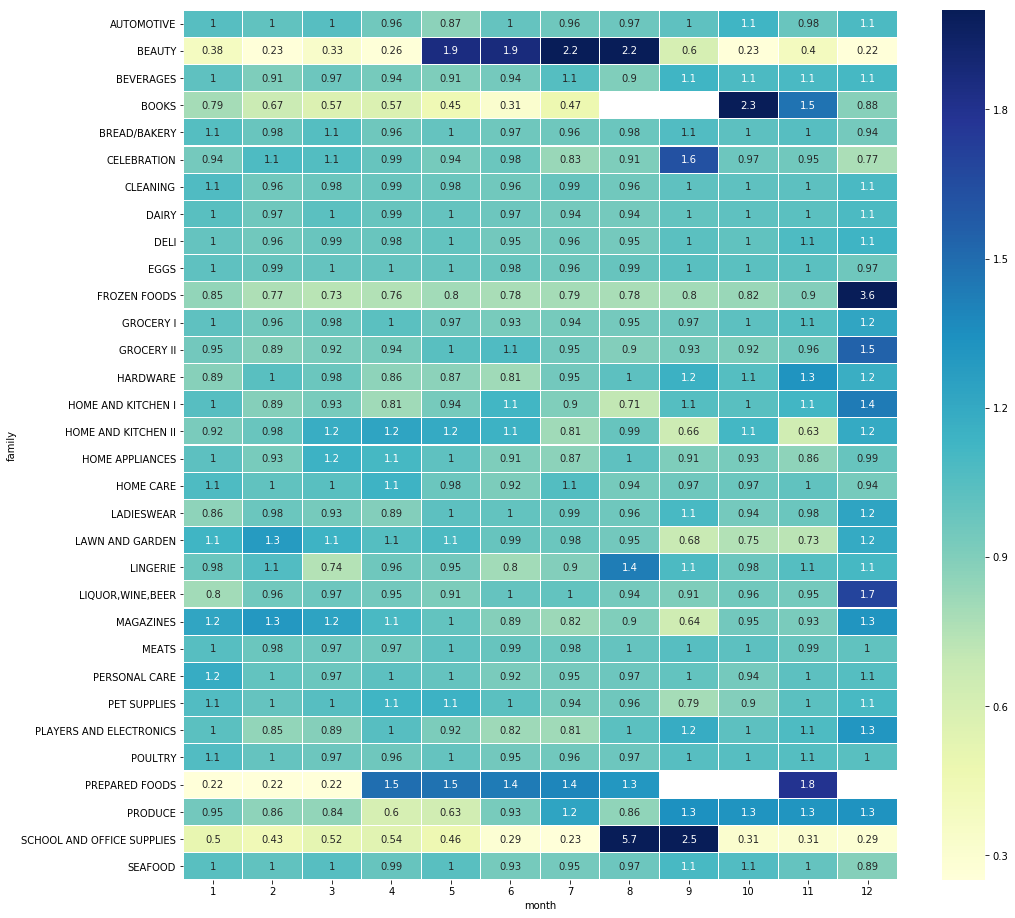

In [33]:
fig, ax = plt.subplots(figsize=(16,16)) 
ax = sns.heatmap(norm_mean_month, annot=True, vmin=0.25, vmax=2.0, linewidths=.2, cmap="YlGnBu", ax=ax)

### Sum sales

In [34]:
sum_sales = df_sales.groupby('date').unit_sales.sum()
sum_sales.index = pd.to_datetime(sum_sales.index)

In [35]:
sum_sales = sum_sales.reindex(dates)
sum_sales.isnull().sum()

6

In [36]:
sum_sales[sum_sales.isnull()]

2014-12-25   NaN
2015-01-01   NaN
2015-12-25   NaN
2016-01-01   NaN
2016-12-25   NaN
2017-01-01   NaN
Name: unit_sales, dtype: float64

In [37]:
sum_sales = sum_sales.fillna(0).astype(int)

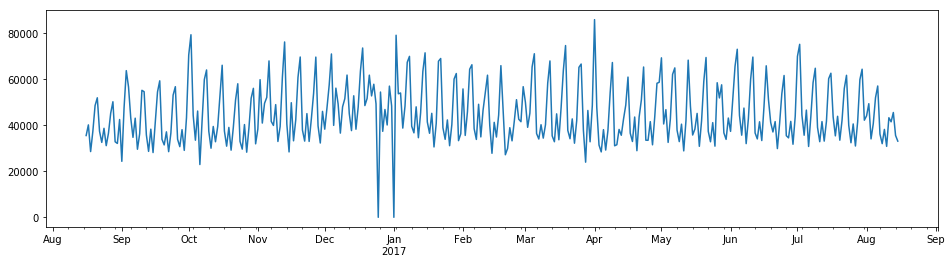

In [38]:
sum_sales.tail(365).plot(figsize=(16, 4));

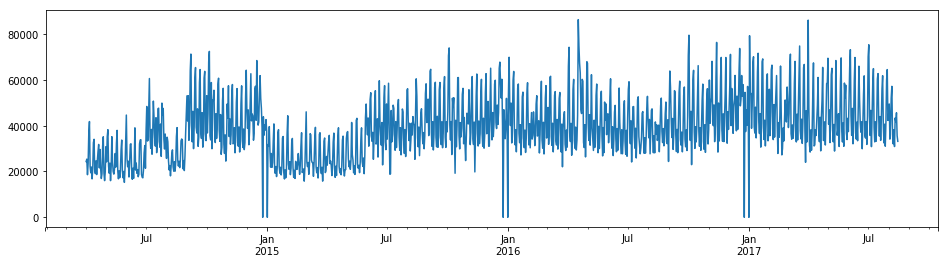

In [39]:
sum_sales.plot(figsize=(16, 4));

# Autocorelation

In [40]:
sum_sales.corr(sum_sales.shift(1))

0.48578085698111745

In [41]:
autocorr = [(lag, sum_sales.corr(sum_sales.shift(lag))) for lag in range(1, 366)]
autocorr = pd.DataFrame(autocorr, columns=['lag', 'corr'])
autocorr.set_index('lag', inplace=True)

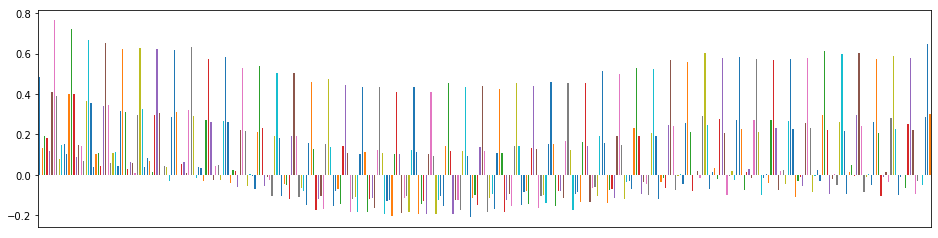

In [42]:
ax = autocorr['corr'].plot(kind='bar', figsize=(16, 4))
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

In [43]:
seq = cycle(range(1, 8 ))
autocorr['day_lag']  = [next(seq) for count in range(autocorr.shape[0])]

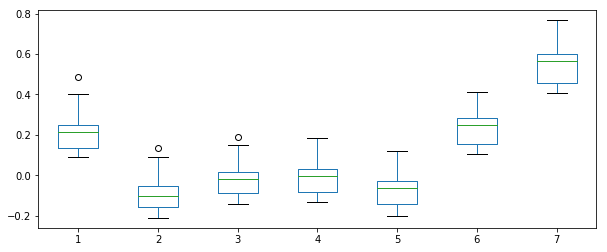

In [44]:
autocorr.pivot(columns='day_lag', values='corr').plot(kind='box', figsize=(10, 4))

In [45]:
df_corr = pd.DataFrame()
for n in range(1,8):
    dfs = autocorr.pivot(columns='day_lag', values='corr')[n]
    df_corr[n] = dfs[dfs.notnull()].reset_index(drop=True)

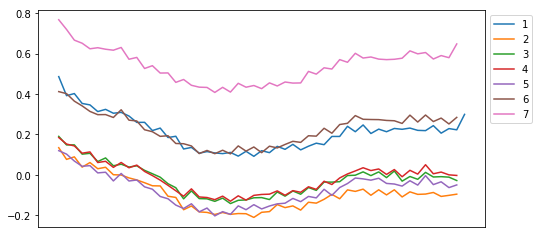

In [46]:
ax = df_corr.plot(figsize=(8, 4))
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
ax.legend(bbox_to_anchor=(1, 0.999))

In [47]:
from sklearn import metrics

In [48]:
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / np.abs(y_true))

In [49]:
def show_metrics(y_true,y_pred):
    df_metrics = pd.DataFrame()
    df_metrics.loc['MAE','metrics'] = metrics.mean_absolute_error(y_true, y_pred)
    df_metrics.loc['MSE','metrics'] = metrics.mean_squared_error(y_true, y_pred)
    df_metrics.loc['RMSE','metrics'] = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    df_metrics.loc['R2','metrics'] = metrics.r2_score(y_true, y_pred)
    df_metrics.loc['CORR','metrics'] = y_true.corr(y_pred)
    df_metrics.loc['MAPE','metrics'] = mape(y_true[y_true > 0], y_pred[y_true > 0])
    return df_metrics

In [50]:
y_true = sum_sales
y_pred = sum_sales.shift(7)
y_true = y_true[y_pred.notnull()]
y_pred = y_pred[y_pred.notnull()]

In [51]:
pd.options.display.float_format = '{:.2f}'.format
show_metrics(y_true,y_pred)

,metrics
MAE,5960.55
MSE,83088110.11
RMSE,9115.27
R2,0.53
CORR,0.77
MAPE,14.87


# Baseline

In [52]:
import calendar

In [53]:
sum_sales.head(1)

2014-04-01    24333
Freq: D, Name: unit_sales, dtype: int64

In [54]:
calendar.TextCalendar(calendar.MONDAY).prmonth(2014, 4)

     April 2014
Mo Tu We Th Fr Sa Su
    1  2  3  4  5  6
 7  8  9 10 11 12 13
14 15 16 17 18 19 20
21 22 23 24 25 26 27
28 29 30


In [55]:
sum_sales.resample('1w-tue', closed='left', label='right').sum().head()

2014-04-08    192557
2014-04-15    166368
2014-04-22    169161
2014-04-29    172283
2014-05-06    186595
Freq: W-TUE, Name: unit_sales, dtype: int64

In [56]:
#weekly avarage
baseline = sum_sales.resample('1w', label='right', closed='left').mean().resample('1d').max()
baseline.head(15)

2014-04-06   25723.60
2014-04-07        nan
2014-04-08        nan
2014-04-09        nan
2014-04-10        nan
2014-04-11        nan
2014-04-12        nan
2014-04-13   25114.00
2014-04-14        nan
2014-04-15        nan
2014-04-16        nan
2014-04-17        nan
2014-04-18        nan
2014-04-19        nan
2014-04-20   24330.86
Freq: D, Name: unit_sales, dtype: float64

In [57]:
baseline = baseline.ffill()

In [58]:
baseline.head()

2014-04-06   25723.60
2014-04-07   25723.60
2014-04-08   25723.60
2014-04-09   25723.60
2014-04-10   25723.60
Freq: D, Name: unit_sales, dtype: float64

In [59]:
y_pred = sum_sales.shift(7)

In [60]:
df_bl = pd.concat((sum_sales, y_pred, baseline), axis=1)
df_bl.columns = ['y_true', 'y_pred', 'baseline']
df_bl.head(9)

,y_true,y_pred,baseline
2014-04-01,24333.00,nan,nan
2014-04-02,25381.00,nan,nan
2014-04-03,18590.00,nan,nan
2014-04-04,23479.00,nan,nan
2014-04-05,36835.00,nan,nan
2014-04-06,41775.00,nan,25723.60
2014-04-07,22164.00,nan,25723.60
2014-04-08,19399.00,24333.00,25723.60
2014-04-09,21936.00,25381.00,25723.60


In [61]:
df_bl.tail(9)

,y_true,y_pred,baseline
2017-08-12,41556.00,52006.00,46729.29
2017-08-13,45605.00,57138.00,39912.14
2017-08-14,35624.00,36205.00,39912.14
2017-08-15,33145.00,32045.00,39912.14
2017-08-16,nan,nan,39912.14
2017-08-17,nan,nan,39912.14
2017-08-18,nan,nan,39912.14
2017-08-19,nan,nan,39912.14
2017-08-20,nan,nan,38124.67


In [62]:
df_bl = df_bl[df_bl.isnull().sum(axis=1) == 0]

In [63]:
pd.options.display.float_format = '{:.2f}'.format
df_bl_metrcs = pd.DataFrame()
df_bl_metrcs['7d_shift'] = show_metrics(df_bl.y_true,df_bl.y_pred).metrics
df_bl_metrcs['baseline'] = show_metrics(df_bl.y_true,df_bl.baseline).metrics
df_bl_metrcs

,7d_shift,baseline
MAE,5960.55,9166.21
MSE,83088110.11,136462749.31
RMSE,9115.27,11681.73
R2,0.53,0.23
CORR,0.77,0.50
MAPE,14.87,23.61


In [64]:
1 - ( df_bl_metrcs.loc['MAE',:][0] / df_bl_metrcs.loc['MAE',:][1] )

0.34972517917467727

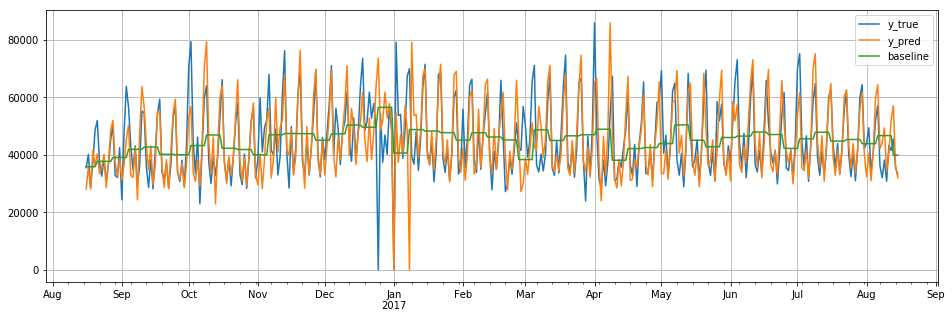

In [65]:
df_bl.tail(365).plot(figsize=(16, 5), grid=True);

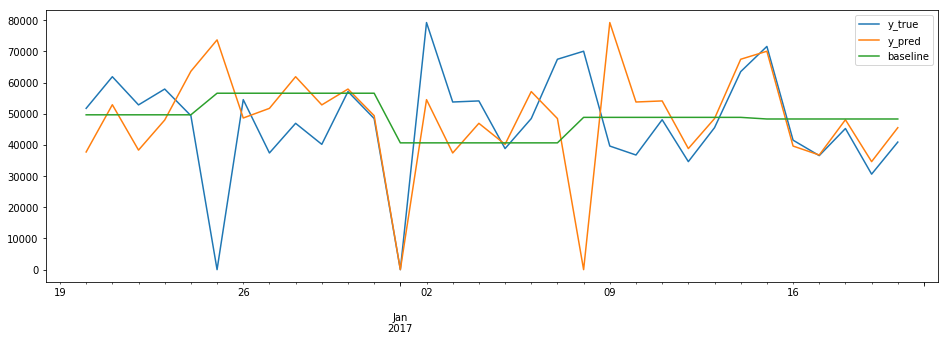

In [66]:
df_bl['2016-12-20':'2017-01-20'].plot(figsize=(16, 5));

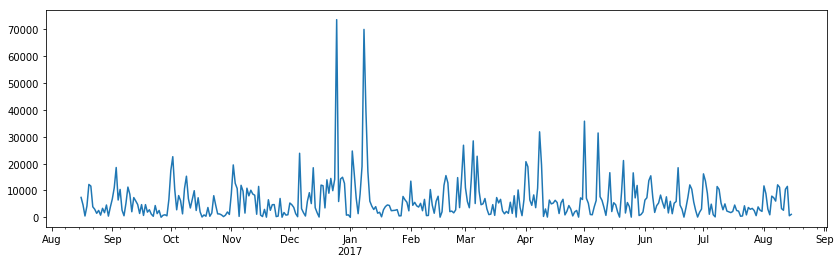

In [67]:
#7d shift
np.abs(df_bl.y_true - df_bl.y_pred).tail(365).plot(figsize=(14, 4));

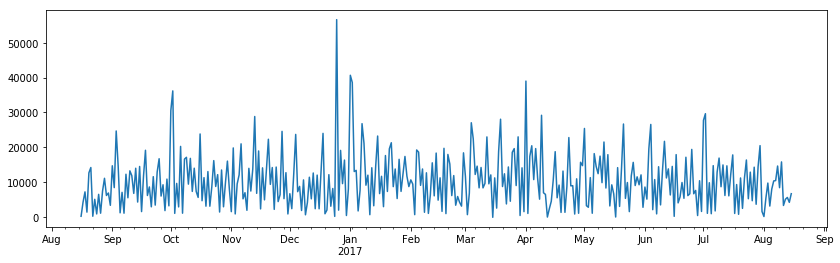

In [68]:
#baseline
np.abs(df_bl.y_true - df_bl.baseline).tail(365).plot(figsize=(14, 4));

In [69]:
err_7ds = pd.DataFrame(np.abs(df_bl.y_true - df_bl.y_pred), columns=['abs_err'])
err_7ds['dow'] = err_7ds.index.map(lambda x: x.dayofweek+1)
err_7ds['month'] = err_7ds.index.map(lambda x: x.month)

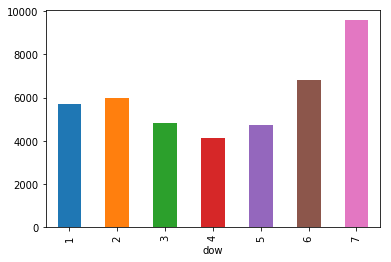

In [70]:
err_7ds.groupby('dow').abs_err.mean().plot(kind='bar');

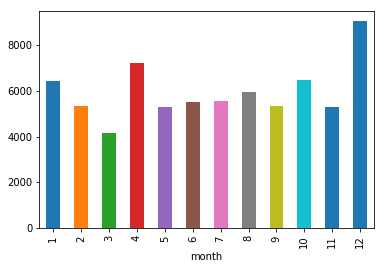

In [71]:
err_7ds.groupby('month').abs_err.mean().plot(kind='bar');

In [145]:
df_prep = pd.DataFrame( sum_sales )
df_prep = pd.merge(df_prep, holidays, left_index=True, right_on='date', how='left')
df_prep.head(3)

,unit_sales,date,holiday_flag,workday,weekend,work_on_weekend
0,24333,2014-04-01,0,1,0,0
1,25381,2014-04-02,0,1,0,0
2,18590,2014-04-03,0,1,0,0


In [146]:
df_prep['dow'] = df_prep['date'].map(lambda x: x.dayofweek)
df_prep['woy'] = df_prep['date'].map(lambda x: x.weekofyear)
df_prep['doy'] = df_prep['date'].map(lambda x: x.dayofyear)
df_prep['year'] = df_prep['date'].map(lambda x: x.year)
df_prep['month'] = df_prep['date'].map(lambda x: x.month)
df_prep['day'] = df_prep['date'].map(lambda x: x.day)
df_prep['wom'] = df_prep['day'].map(lambda x: (x-1) // 7 +1)
df_prep['trend'] = range(df_prep.shape[0])
df_prep.head(3)

,unit_sales,date,holiday_flag,workday,weekend,work_on_weekend,dow,woy,doy,year,month,day,wom,trend
0,24333,2014-04-01,0,1,0,0,1,14,91,2014,4,1,1,0
1,25381,2014-04-02,0,1,0,0,2,14,92,2014,4,2,1,1
2,18590,2014-04-03,0,1,0,0,3,14,93,2014,4,3,1,2


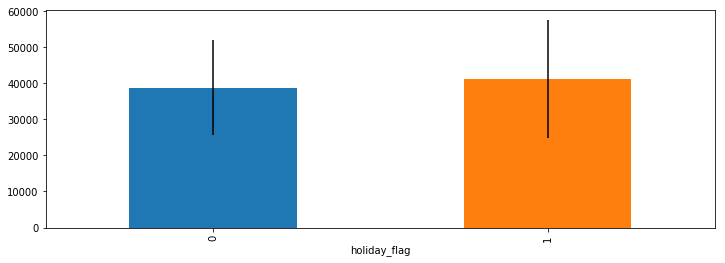

In [147]:
hd_means = df_prep.groupby('holiday_flag').unit_sales.mean()
hd_error = df_prep.groupby('holiday_flag').unit_sales.std()

fig, ax = plt.subplots()
hd_means.plot(kind='bar', yerr=hd_error, ax=ax, figsize=(12, 4));

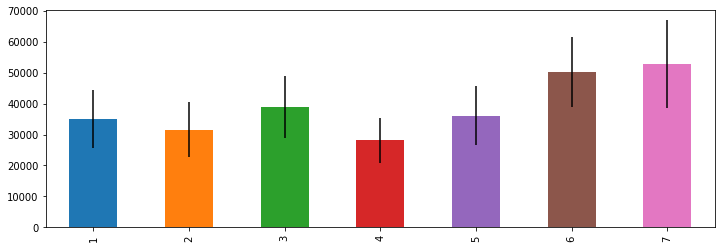

In [148]:
dow_means = df_prep.groupby('dow').unit_sales.mean()
dow_means.index = np.arange(1,8,1)
dow_error = df_prep.groupby('dow').unit_sales.std()
dow_error.index = np.arange(1,8,1)

fig, ax = plt.subplots()
dow_means.plot(kind='bar', yerr=dow_error, ax=ax, figsize=(12, 4));

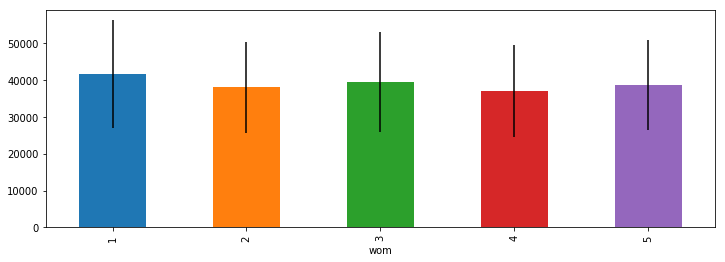

In [149]:
wom_means = df_prep.groupby('wom').unit_sales.mean()
wom_error = df_prep.groupby('wom').unit_sales.std()

fig, ax = plt.subplots()
wom_means.plot(kind='bar', yerr=wom_error, ax=ax, figsize=(12, 4));

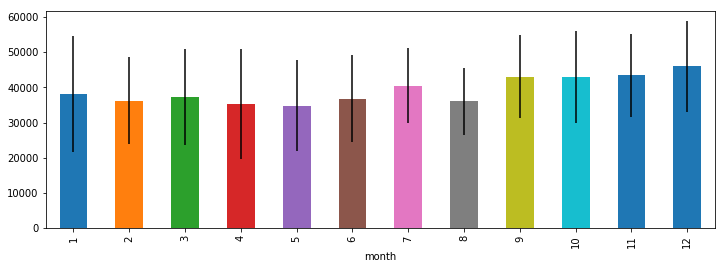

In [150]:
mth_means = df_prep.groupby('month').unit_sales.mean()
mth_error = df_prep.groupby('month').unit_sales.std()

fig, ax = plt.subplots()
mth_means.plot(kind='bar', yerr=mth_error, ax=ax, figsize=(12, 4));

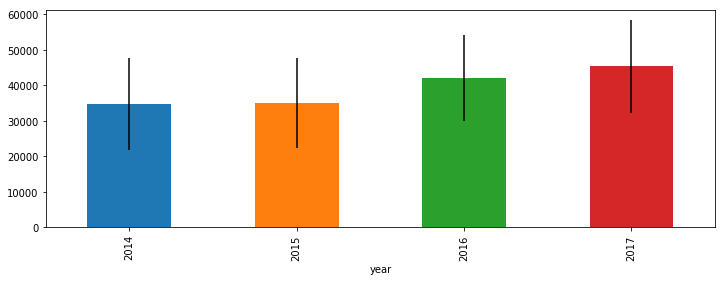

In [151]:
yr_means = df_prep.groupby('year').unit_sales.mean()
yr_error = df_prep.groupby('year').unit_sales.std()

fig, ax = plt.subplots()
yr_means.plot(kind='bar', yerr=yr_error, ax=ax, figsize=(12, 4));

In [152]:
df_prep = df_prep.set_index('date')

In [153]:
train = df_prep[:'2017-06'].copy()
test = df_prep['2017-07':'2017-08'].copy()

In [154]:
train.shape, test.shape

((1187, 13), (46, 13))

In [155]:
features = ['year']
target = 'unit_sales'

y_train, x_train = train[target], train[features]
y_test, x_test = test[target], test[features]

lr = LinearRegression()
lr = lr.fit(x_train, y_train)
test['lr_y_pred'] = lr.predict(x_test)

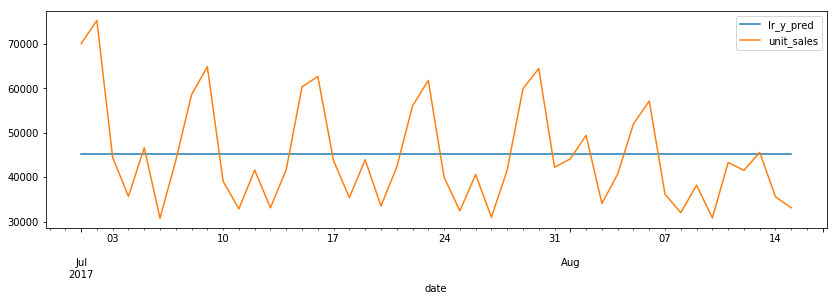

In [156]:
test[['lr_y_pred', target]].plot(figsize=(14, 4));

In [157]:
for col in ['dow', 'woy', 'doy', 'month', 'day', 'wom', 'year']:
    df_prep[col] = pd.Categorical(df_prep[col])

In [158]:
df_dummy = pd.get_dummies(df_prep[['dow', 'woy', 'doy', 'month', 'day', 'wom']])
dummy_features = df_dummy.columns
df_prep = pd.concat( (df_prep, df_dummy), axis=1 )

In [163]:
df_prep = pd.concat( (df_prep, family_df), axis=1 )

In [165]:
features = ['year', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
target = 'unit_sales'

train = df_prep[:'2017-06'].copy()
test = df_prep['2017-07':'2017-08'].copy()

y_train, x_train = train[target], train[features]
y_test, x_test = test[target], test[features]

lr = LinearRegression()
lr = lr.fit(x_train, y_train)
test['lr_y_pred'] = lr.predict(x_test)

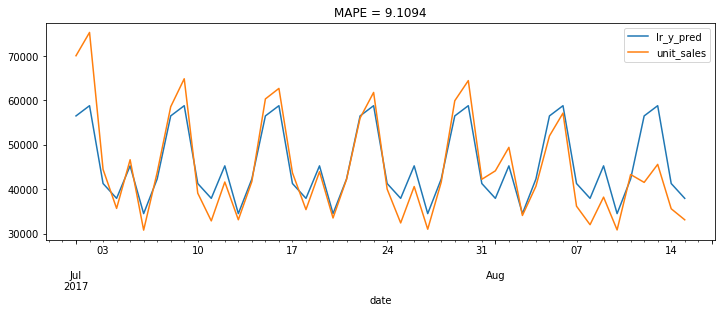

In [166]:
test[['lr_y_pred', target]].plot(
    title='MAPE = {:.4f}'.format(mape(test[target], test.lr_y_pred)),
    figsize=(12, 4)
);

In [167]:
#Shifted variables
df_prep['s7'] = df_prep['unit_sales'].shift(7)
df_prep['s14'] = df_prep['unit_sales'].shift(14)
df_prep['s21'] = df_prep['unit_sales'].shift(21)
df_prep['s28'] = df_prep['unit_sales'].shift(28)

In [168]:
df_prep = df_prep[df_prep.s28.notnull()].copy()

In [169]:
features = ['year', 
            's7', 's14', 's21', 's28', 
            'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',  
            'day_30', 'day_31', 'day_1', 'day_2', 
            'day_14', 'day_15', 'day_16']

target = 'unit_sales'

train = df_prep[:'2017-06'].copy()
test = df_prep['2017-07':'2017-08'].copy()

y_train, x_train = train[target], train[features]
y_test, x_test = test[target], test[features]

lr = LinearRegression()
lr = lr.fit(x_train, y_train)
test['lr_y_pred'] = lr.predict(x_test)

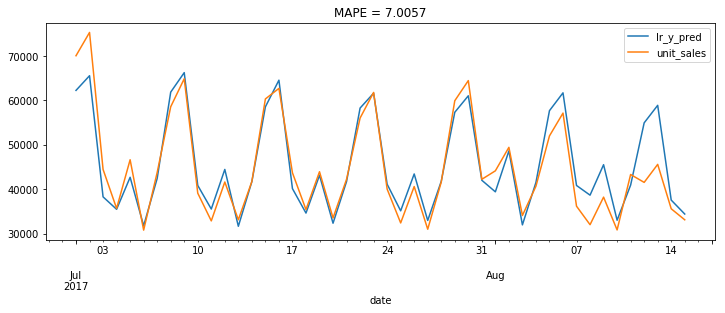

In [170]:
test[['lr_y_pred', target]].plot(
    title='MAPE = {:.4f}'.format(mape(test[target], test.lr_y_pred)),
    figsize=(12, 4)
);

In [171]:
#Moving avarages
df_prep['ma7'] = df_prep['unit_sales'].rolling(7).mean()
df_prep['ma14'] = df_prep['unit_sales'].rolling(14).mean()
df_prep['ma21'] = df_prep['unit_sales'].rolling(21).mean()
df_prep['ma28'] = df_prep['unit_sales'].rolling(28).mean()

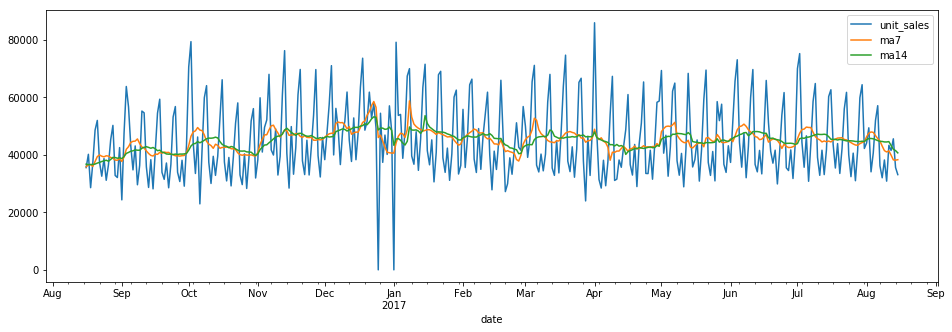

In [172]:
df_prep[['unit_sales', 'ma7', 'ma14']].tail(365).plot(figsize=(16, 5));

In [173]:
df_prep = df_prep[df_prep.ma28.notnull()].copy()

In [174]:
features = ['year', 
            's7', 's14', 's21', 's28',
            'ma7', 'ma14', 'ma21', 'ma28',
            'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',  
            'day_30', 'day_31', 'day_1', 'day_2', 
            'day_14', 'day_15', 'day_16']

target = 'unit_sales'

train = df_prep[:'2017-06'].copy()
test = df_prep['2017-07':'2017-08'].copy()

y_train, x_train = train[target], train[features]
y_test, x_test = test[target], test[features]

lr = LinearRegression()
lr = lr.fit(x_train, y_train)
test['lr_y_pred'] = lr.predict(x_test)

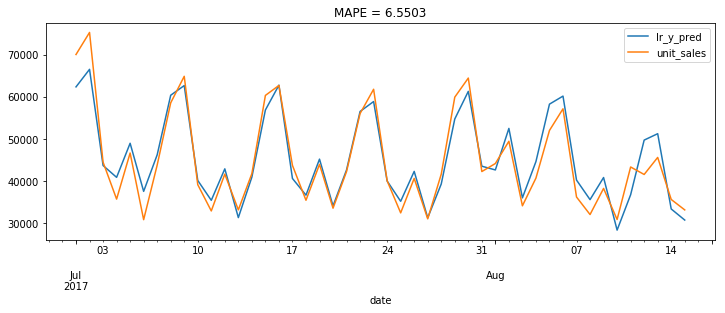

In [175]:
test[['lr_y_pred', target]].plot(
    title='MAPE = {:.4f}'.format(mape(test[target], test.lr_y_pred)),
    figsize=(12, 4)
);

In [176]:
df_prep.year = df_prep.year.astype(int)

In [177]:
features = ['year', 
            's7', 's14', 's21', 's28',
            'ma7', 'ma14', 'ma21', 'ma28',
            'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',  
            'day_30', 'day_31', 'day_1', 'day_2', 
            'day_14', 'day_15', 'day_16']

target = 'unit_sales'

train = df_prep[:'2017-06'].copy()
test = df_prep['2017-07':'2017-08'].copy()

y_train, x_train = train[target], train[features]
y_test, x_test = test[target], test[features]

In [178]:
params = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'lambda': np.arange(1,10,1),
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.75,1.0],
        'max_depth': np.arange(10,20,2),
        'n_estimators' : np.arange(500,700,10),
        'early_stopping_rounds': [10]
        }

In [179]:
nthreads = multiprocessing.cpu_count()
xgb_model = xgb.XGBRegressor(learning_rate=0.03, silent=True, nthread=nthreads,seed=42)
kf = KFold(n_splits=3,random_state=42,shuffle = True)
random_search = RandomizedSearchCV(xgb_model, params,
                                   n_iter=10,
                                   cv=kf.split(x_train,y_train),
                                   verbose=0,
                                   random_state=42 )
warnings.filterwarnings('ignore')
random_search.fit(x_train, y_train)
random_search.best_estimator_
warnings.filterwarnings('always')
test['gbt_y_pred'] = random_search.best_estimator_.predict(x_test)

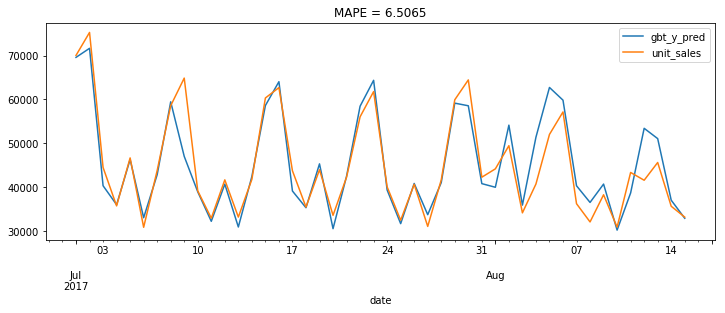

In [180]:
test[['gbt_y_pred', target]].plot(
    title='MAPE = {:.4f}'.format(mape(test[target], test.gbt_y_pred)),
    figsize=(12, 4)
);

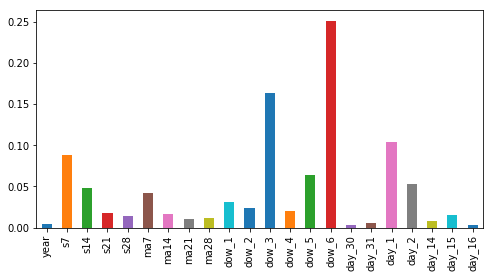

In [181]:
pd.Series(random_search.best_estimator_.feature_importances_, index=features).plot(kind='bar', figsize=(8, 4) );

In [182]:
warnings.filterwarnings( 'ignore' )
errs = {}
train_timeline = pd.date_range( start='2014-05-01', end='2017-05-01', freq='1m' )
test = df_prep[ '2017-07':'2017-08' ].copy()
for tlidx in range( len( train_timeline ) ):
    st = train_timeline[ tlidx]
    train = df_prep[ st:'2017-06' ].copy()                      
    y_train, x_train = train[ target ], train[ features ]
    y_test, x_test = test[ target ], test[ features ]
    nthreads = multiprocessing.cpu_count()
    xgb_model = xgb.XGBRegressor( learning_rate=0.03, silent=True, nthread=nthreads,seed=42)
    kf = KFold( n_splits=3, random_state=42, shuffle = True )
    random_search = RandomizedSearchCV( xgb_model, params, n_iter=10, cv=kf.split(x_train,y_train),
                                        verbose=0, random_state=42 )
    random_search.fit( x_train, y_train )
    y_pred = random_search.best_estimator_.predict( x_test )
    errs[ tlidx-len( train_timeline ) ] = mape( y_test, y_pred )
warnings.filterwarnings( 'always' )

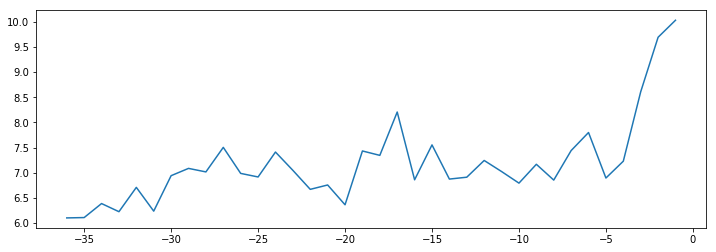

In [183]:
#Amount of data from past in months
pd.Series(errs).plot( figsize=(12, 4));

In [184]:
features = ['holiday_flag','workday','weekend','work_on_weekend','year',
            's7', 's14', 's21', 's28','ma7', 'ma14', 'ma21', 'ma28'] + list(dummy_features) + imp_pfamilys

target = 'unit_sales'

train = df_prep[:'2017-06'].copy()
test = df_prep['2017-07':'2017-08'].copy()

y_train, x_train = train[target], train[features]
y_test, x_test = test[target], test[features]

In [185]:
nthreads = multiprocessing.cpu_count()
xgb_model = xgb.XGBRegressor(learning_rate=0.03, silent=True, nthread=nthreads,seed=42)
kf = KFold(n_splits=3,random_state=42,shuffle = True)
random_search = RandomizedSearchCV(xgb_model, params,
                                   n_iter=10,
                                   cv=kf.split(x_train,y_train),
                                   verbose=0,
                                   random_state=42 )
warnings.filterwarnings('ignore')
random_search.fit(x_train, y_train)
random_search.best_estimator_
warnings.filterwarnings('always')
test['gbt_y_pred'] = random_search.best_estimator_.predict(x_test)

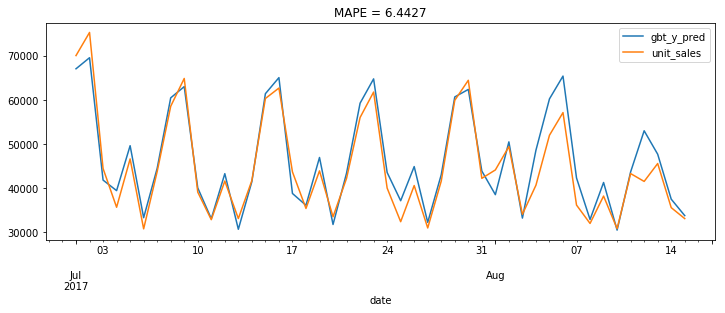

In [186]:
test[['gbt_y_pred', target]].plot(
    title='MAPE = {:.4f}'.format(mape(test[target], test.gbt_y_pred)),
    figsize=(12, 4)
);

In [187]:
#Selecting most important features
imp_s = pd.Series(random_search.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

In [216]:
sen = 0.002
new_features = list( imp_s[ imp_s > sen ].index )

In [217]:
target = 'unit_sales'

train = df_prep[:'2017-06'].copy()
test = df_prep['2017-07':'2017-08'].copy()

y_train, x_train = train[target], train[new_features]
y_test, x_test = test[target], test[new_features]

In [218]:
nthreads = multiprocessing.cpu_count()
xgb_model = xgb.XGBRegressor(learning_rate=0.03, silent=True, nthread=nthreads,seed=42)
kf = KFold(n_splits=3,random_state=42,shuffle = True)
random_search = RandomizedSearchCV(xgb_model, params,
                                   n_iter=10,
                                   cv=kf.split(x_train,y_train),
                                   verbose=0,
                                   random_state=42 )
warnings.filterwarnings('ignore')
random_search.fit(x_train, y_train)
random_search.best_estimator_
warnings.filterwarnings('always')
test['gbt_y_pred'] = random_search.best_estimator_.predict(x_test)

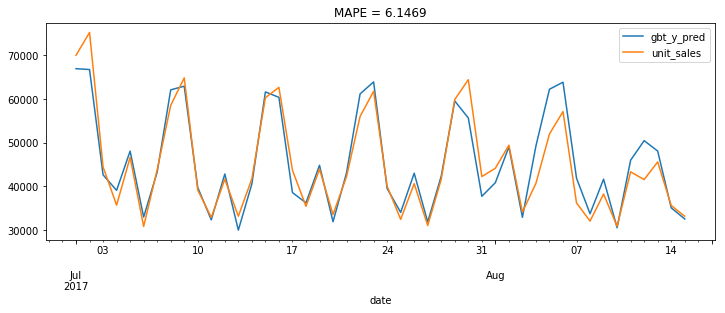

In [219]:
test[['gbt_y_pred', target]].plot(
    title='MAPE = {:.4f}'.format(mape(test[target], test.gbt_y_pred)),
    figsize=(12, 4)
);

In [220]:
train['gbt_y_pred'] = random_search.best_estimator_.predict(x_train)
train['res'] = train['unit_sales'] - train['gbt_y_pred']

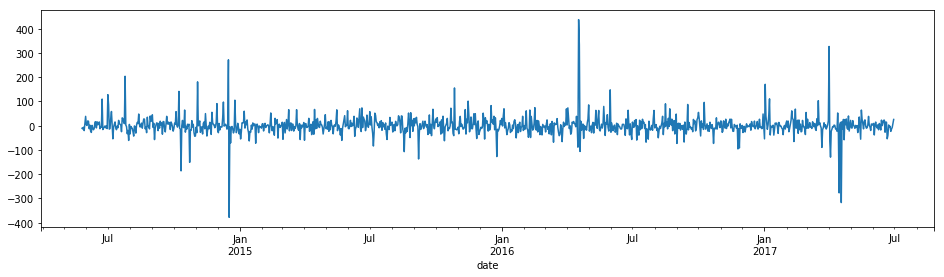

In [221]:
train['res'].plot(figsize=(16, 4));

In [222]:
autocorr = [(lag, train['res'].corr(train['res'].shift(lag))) for lag in range(1, 60)]

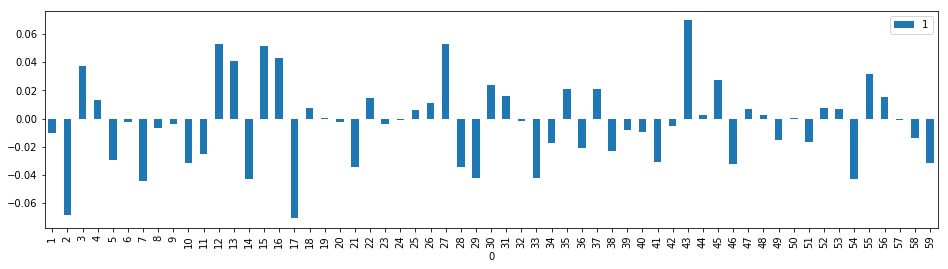

In [223]:
pd.DataFrame(autocorr).set_index(0).plot(kind='bar', figsize=(16, 4));

In [224]:
autocorr_diff = [(lag, train['res'].diff().corr(train['res'].diff().shift(lag))) for lag in range(1, 60)]

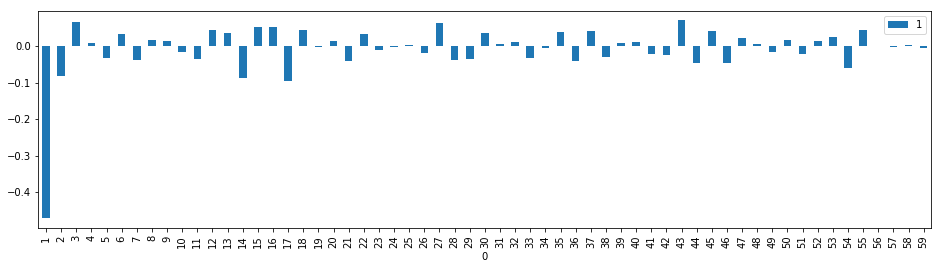

In [225]:
pd.DataFrame(autocorr_diff).set_index(0).plot(kind='bar', figsize=(16, 4));

In [226]:
mrg_trte = pd.concat((train, test),sort=False)
mrg_trte['diff'] = mrg_trte['res'].diff()
mrg_trte['diff_1'] = mrg_trte['diff'].shift(1)

In [227]:
mrg_trte[['diff', 'diff_1']].tail(50).head(10)

,diff,diff_1
date,,
2017-06-27,9.50,-20.97
2017-06-28,6.90,9.50
2017-06-29,15.32,6.90
2017-06-30,17.35,15.32
2017-07-01,nan,17.35
2017-07-02,nan,nan
2017-07-03,nan,nan
2017-07-04,nan,nan
2017-07-05,nan,nan


In [228]:
mrg_trte_sl = mrg_trte.loc['2014-05-28':'2017-06-30', ['diff', 'diff_1']]

In [229]:
model_lr = LinearRegression()
model_lr = model_lr.fit(mrg_trte_sl[['diff']], mrg_trte_sl[['diff_1']])

In [230]:
for day in pd.date_range('2017-07-01', '2017-08-15', freq='1d'):
    mrg_trte.loc[day:day, 'diff'] = model_lr.predict(mrg_trte.loc[day:day,['diff_1']])
    mrg_trte['diff_1'] = mrg_trte['diff'].shift(1)

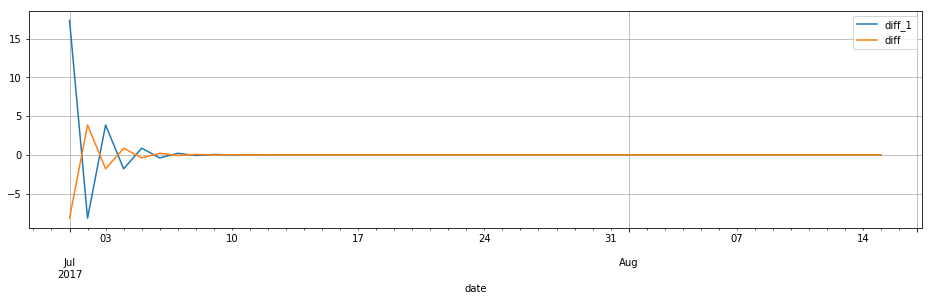

In [231]:
mrg_trte.loc['2017-07-01':'2017-08-15', ['diff_1', 'diff']].plot(figsize=(16, 4), grid=True);

In [232]:
train['res_diff'] = train['res'].diff()
train['sft_res_diff'] = train['res'].shift(1)
train['gbt_y_pred_diff'] = train['gbt_y_pred'].diff()

In [233]:
kf = KFold(n_splits=10, random_state=45, shuffle=True)

In [234]:
train_t = train[train['sft_res_diff'].notnull()].copy()

In [235]:
test['gbt_y_pred_diff'] = test['gbt_y_pred'].diff()
test.loc['2017-07-01','gbt_y_pred_diff'] = test['gbt_y_pred'][0] - train['gbt_y_pred'].tail(1).values[0]

In [236]:
y_train_t, x_train_t = train_t['sft_res_diff'], train_t['gbt_y_pred_diff']
x_test = test['gbt_y_pred_diff']
lr = LinearRegression()
lr = lr.fit(x_train_t.to_frame(), y_train_t)
test['res_diff'] = pd.Series(lr.predict(x_test.to_frame()), index=x_test.index)

In [237]:
test['m_pred'] = test['res_diff'] + test['gbt_y_pred']

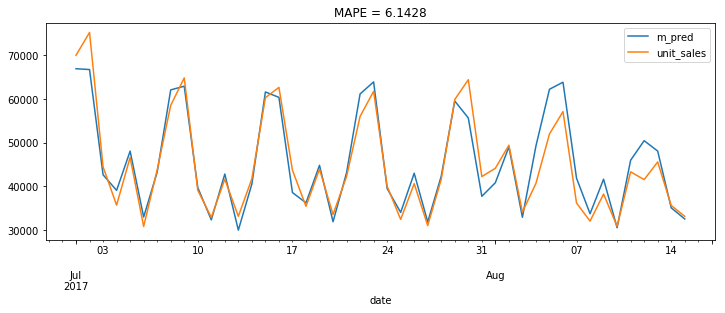

In [238]:
test[['m_pred', target]].plot(
    title='MAPE = {:.4f}'.format(mape(test[target], test.m_pred)),
    figsize=(12, 4)
);